Names: Fabio Lenherr & Kaj Habegger

Copyright (C) 2023  Fabio Lenherr, Kaj Habegger

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.


## Install required libraries

In [11]:
# This is simply a workaround if the pipenv is not properly loaded
! pip install tensorflow
! pip install matplotlib
! pip install scikit-learn

# Pokegpt

## Idea

Our idea was to create a classification model that will determine the pokemon type based on the image provided.
We do this with the data of the first generation to keep both the image amount and type amount limited.
We fully understand, that this model will not be 100% correct, as pokemon will not always have a type that is solely dependent on the color or body. In other words, with some pokemon the creators were a bit too creative with their interpretation of how a type should be represented.

## Notes

- There is a problem with the pokemon that we needed to solve. Our model is designed to end up with one classification, however there are many pokemon with a dual-type. For example one pokemon might have the type Water+Ground. In this case we chose the first type for the vast majority of pokemon, with a few exceptions where we found that the secondary type makes more sense.

- Some classes do not feature enough pokemon to be included for the assignment, these classes were simply removed. Pokemon featuring dual-types with a removed type will simply live on in the other class should that be included.

## Acknowledgements

- Dataset 1 [Pokemon Generation One](https://www.kaggle.com/datasets/thedagger/pokemon-generation-one?resource=download) by HarshitDwivedi, License GPL2.0
- Dataset 2 [Pokemon Images, First Generation(17000 files)](https://www.kaggle.com/datasets/mikoajkolman/pokemon-images-first-generation17000-files) by Mikołaj Kolman, License GPL2.0
- Template for notebook [https://www.tensorflow.org/tutorials/keras/classification](Basic classification: Classify images of clothing) by François Chollet, License Apache 2.0

## Setup

### Imports

In [13]:
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as layers
from sklearn.model_selection import KFold 

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Sklearn for Confusion Matrix
from sklearn.metrics import confusion_matrix

# os for environment variables
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"


print(tf.__version__)

2.11.0


### GPU Detection

In [14]:
# Check whether GPU is available for ML or not
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-03-17 14:17:55.029834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 14:17:55.029883: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 14:17:55.029928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (spaceship): /proc/driver/nvidia/version does not exist


### Load base data

In [15]:
# Base variables used
train_dir = 'datasets/dataset_training/'
test_dir = 'datasets/dataset_testing/'
batch_size = 32
img_height = 256
img_width = 256

# We split the base data into validation and testing data.
training_ds, validation_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred", # classes can be inferred from folders. We have this structured for this specifically.
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
    subset="both",
    seed=24,
    validation_split=0.2
)

# The testing set is made of a completely different dataset, however it still features the 1.generation of pokemon
testing_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width) # Some preprocessing happening here, resizing the images
)

NotFoundError: Could not find directory datasets/dataset_training/

### Data information and visualization

In [5]:
# Here we simply retrieve all class names that we have available
class_names = training_ds.class_names
num_classes = len(training_ds.class_names)
print(class_names)
# as shown below, some types are left out as they had too few pictures. -> Ice, Ghost, etc.

['bug', 'electric', 'fire', 'fly', 'grass', 'ground', 'normal', 'poison', 'psychic', 'rock', 'water']


### Visualization of Classes

In [6]:
# Example figures for the classes.
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

NameError: name 'plt' is not defined

### Visualization of Tensor

In [15]:
# Shape of each Batch
for image_batch, labels_batch in training_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

2023-03-15 12:04:10.462930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:10.462978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: cHRM chunk does not match sRGB
2023-03-15 12:04:10.555345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.041469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.080854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.156521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.182562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.207919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.264533: W tensorflow/core/lib/png/png_io.cc:88] PN

(32, 256, 256, 3)
(32,)


2023-03-15 12:04:11.831946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 12:04:11.832121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


### Configure the dataset for performance

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# This will ensure the dataset does not become a bottleneck while training your model.
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

# Dataset.prefetch overlaps data preprocessing and model execution while training

## Underfitted Model

The underfitted model features only a single convolutional layer, a max pooling and a dense layer at the end.
This is model is too simple to properly learn from the information provided, this means that we will end up with bad accuracy.

### Model Definition

In [8]:
underfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(4, 64, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes)
])

### Model Complilation

In [9]:
underfitted_model.compile(
    optimizer='adam', # adam optimizer for better optimiztion
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

### Model Fitting

In [10]:
num_epochs=10

underfitted_history = underfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/10
407/407 [==============================] - 43s 96ms/step - loss: 2.4123 - acc: 0.2059 - val_loss: 2.3344 - val_acc: 0.2126
Epoch 2/10
407/407 [==============================] - 37s 90ms/step - loss: 2.2791 - acc: 0.2281 - val_loss: 2.3130 - val_acc: 0.2163
Epoch 3/10
407/407 [==============================] - 36s 89ms/step - loss: 2.2033 - acc: 0.2481 - val_loss: 2.3511 - val_acc: 0.2243
Epoch 4/10
407/407 [==============================] - 36s 89ms/step - loss: 2.1379 - acc: 0.2713 - val_loss: 2.4077 - val_acc: 0.2264
Epoch 5/10
407/407 [==============================] - 36s 90ms/step - loss: 2.0836 - acc: 0.2895 - val_loss: 2.4858 - val_acc: 0.2267
Epoch 6/10
407/407 [==============================] - 37s 90ms/step - loss: 2.0443 - acc: 0.3017 - val_loss: 2.5588 - val_acc: 0.2313
Epoch 7/10
407/407 [==============================] - 37s 90ms/step - loss: 2.0116 - acc: 0.3134 - val_loss: 2.6525 - val_acc: 0.2326
Epoch 8/10
407/407 [==============================] - 36s 89ms

### Model Summary

In [2]:
# While the parameters are still plenty compared to the minimum requirement,
# it is important to note that we 11 classes. 
# This will result in more parameters due to the bigger dense layer.
underfitted_model.summary()

NameError: name 'underfitted_model' is not defined

### Loss and Accuracy calculation

In [12]:
# Define variables used in data visualization for the underfitted model.
acc = underfitted_history.history['acc']
val_acc = underfitted_history.history['val_acc']
loss = underfitted_history.history['loss']
val_loss = underfitted_history.history['val_loss']

### Loss

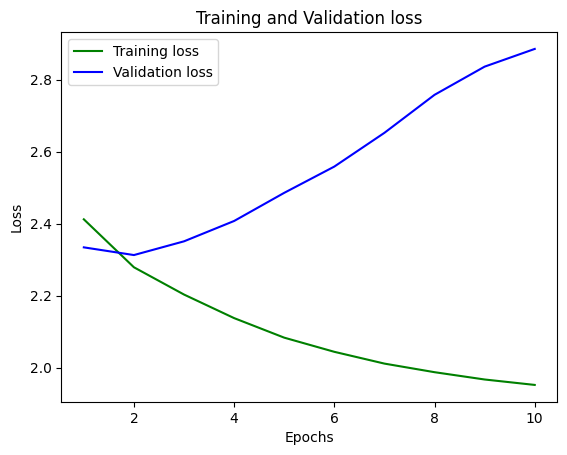

In [14]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

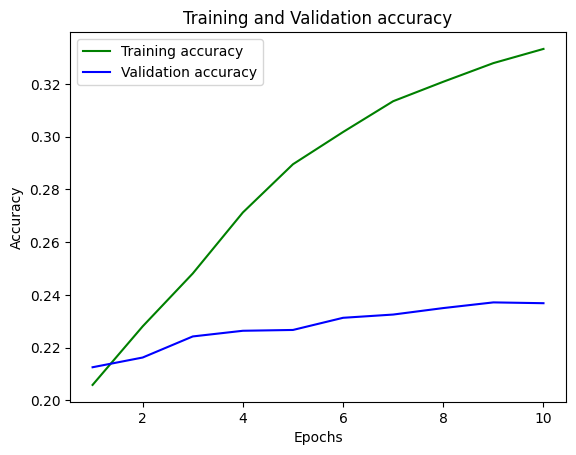

In [15]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Calculation for confusion matrix

In [16]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = underfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

1/1 [==============================] - 1s 620ms/step


### Confusion Matrix

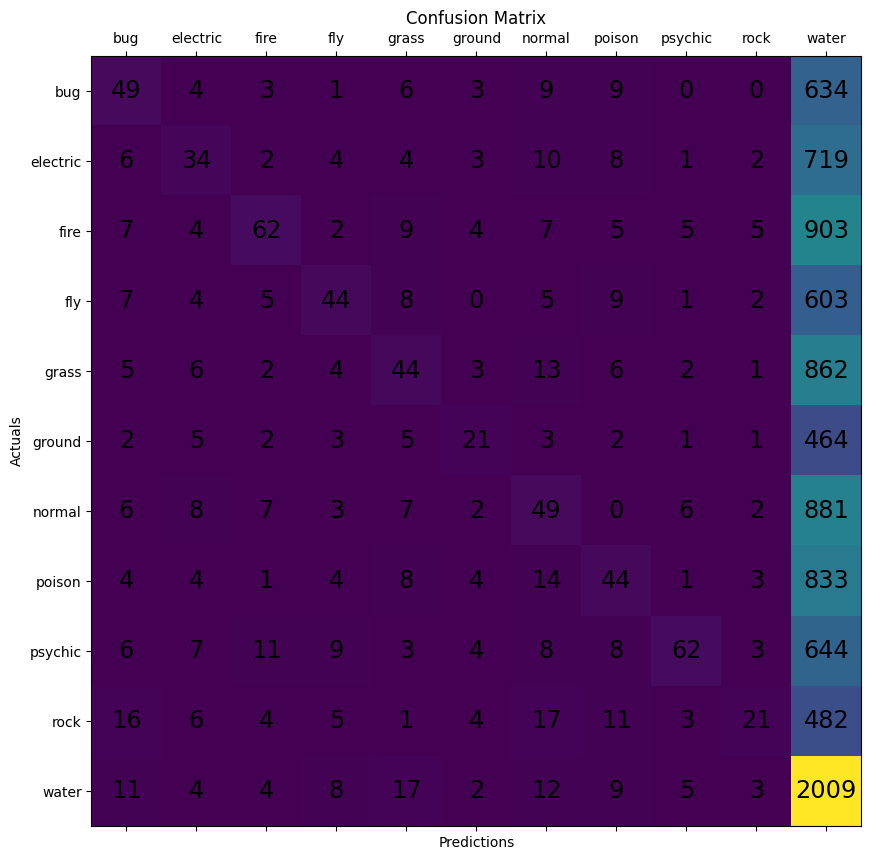

In [19]:
conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix)

# convert data to numpy arrays
ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## Overfitted Model

The overfitted model will feature too many convolutional layers and dense layers, this means we will likely get a really high accuracy with our training data, but our validation/testing data will have horrible results!

### Model Definition

In [7]:
overfitted_model = keras.Sequential([
    layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

### Model Compilation

In [8]:
overfitted_model.compile(
    optimizer='adam', 
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

### Model Fitting

In [9]:
num_epochs=50

overfitted_history = overfitted_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

Epoch 1/50


C:\Users\Kaj\miniconda3\envs\aiap\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


407/407 [==============================] - 40s 85ms/step - loss: 1.7752 - acc: 0.4270 - val_loss: 1.4489 - val_acc: 0.5321
Epoch 2/50
407/407 [==============================] - 30s 75ms/step - loss: 1.1474 - acc: 0.6257 - val_loss: 1.2061 - val_acc: 0.6258
Epoch 3/50
407/407 [==============================] - 31s 75ms/step - loss: 0.7694 - acc: 0.7565 - val_loss: 1.3350 - val_acc: 0.6363
Epoch 4/50
407/407 [==============================] - 31s 75ms/step - loss: 0.4856 - acc: 0.8441 - val_loss: 1.5562 - val_acc: 0.6375
Epoch 5/50
407/407 [==============================] - 31s 75ms/step - loss: 0.2972 - acc: 0.9035 - val_loss: 1.9346 - val_acc: 0.6528
Epoch 6/50
407/407 [==============================] - 31s 75ms/step - loss: 0.1881 - acc: 0.9379 - val_loss: 2.3888 - val_acc: 0.6430
Epoch 7/50
407/407 [==============================] - 31s 75ms/step - loss: 0.1510 - acc: 0.9511 - val_loss: 2.3258 - val_acc: 0.6427
Epoch 8/50
407/407 [==============================] - 31s 75ms/step - los

### Model Summary

In [10]:
# There is a significant increase in parameters compared to the underfitted model.
# This is expected, as this model has more convolutional and dense layers.
overfitted_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 256)       2

### Loss and Accuracy calculation

In [11]:
acc = overfitted_history.history['acc']
val_acc = overfitted_history.history['val_acc']
loss = overfitted_history.history['loss']
val_loss = overfitted_history.history['val_loss']

### Loss

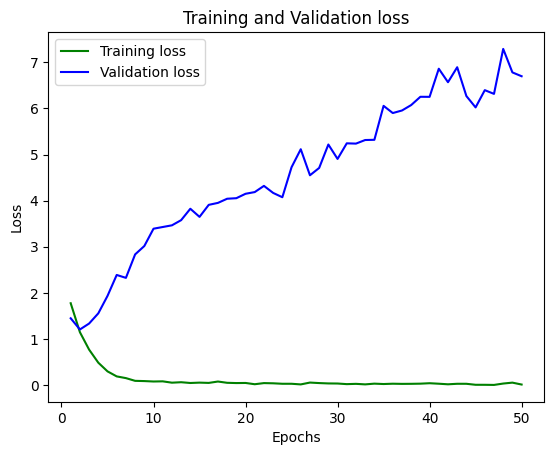

In [16]:
# Plotting training and validation loss
# As expected, the validation loss is actually increasing, while the training loss is minimalized.
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

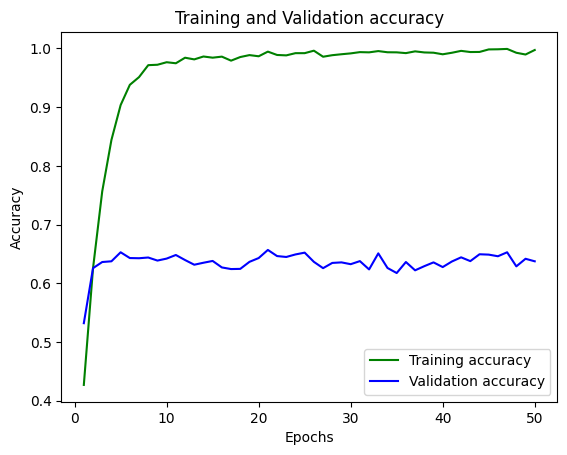

In [15]:
# Plotting training and validation accuracy
# The accurary is comparable to the loss above.
# While the training accuracy is good, the validation accuracy is horrible.
# It is important to note however, that the validation accuracy is somewhat stable, while the loss is increasing!
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Calculation for Confusion Matrix

In [ ]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = overfitted_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix)

ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## Optimized Model

### In here we will use kfold cross validation to ensure that our model is not overffitting or underfitting, the expectation therefore is a good score in both train/validation accuracy as well as test accuracy.

### Reload data without the datasplit, as kfold cross validation takes care of this instead!

In [4]:
train_dir = 'datasets/dataset_training/'
batch_size = 32
img_height = 256
img_width = 256

o_training_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width), # Some preprocessing happening here, resizing the images
)

# variables used in kfold

num_epochs = 10 
splits = 5
scores = [None] * splits
models = [None] * splits

Found 16275 files belonging to 11 classes.


### Setup for Kfold

In [ ]:
train_images = np.concatenate(list(o_training_ds.map(lambda x, y:x)))
train_labels = np.concatenate(list(o_training_ds.map(lambda x, y:y)))

val_images = np.concatenate(list(testing_ds.map(lambda x, y:x)))
val_labels = np.concatenate(list(testing_ds.map(lambda x, y:y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)


kfold = KFold(n_splits=splits, shuffle=True)
iteration = 0
print("kfold setup done")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-15 13:18:33.683227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:33.760382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:33.797551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:33.798481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:33.825522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:33.931471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:34.126799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:34.336970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:34.338466: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:18:41.379089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.416385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.420905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.582321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.757237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.786818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.791726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:41.933889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:42.334632: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:18:47.979299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:47.982176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:47.986582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.087936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.297888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.624533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.625066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.631989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:48.849109: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:18:56.009976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.425654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.426793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'Photoshop ICC profile': 0h: PCS illuminant is not D50
2023-03-15 13:18:56.543077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.573143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.596344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.698621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.736816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:18:56.852612: W tensorfl

2023-03-15 13:19:03.793051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:03.901218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:03.902596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:03.948321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:03.997002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:04.034051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:04.052958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:04.098257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:04.285411: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:19:09.662981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:09.832391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:09.925233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.007349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.318408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.342149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.396792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.515835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:10.550871: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:19:16.904881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:16.955960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.014470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.263571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.271047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.305937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.358600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.358777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:17.359959: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:19:24.207724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.210884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.275641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.275836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.277939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.342072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.653560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.792204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:24.953811: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:19:31.970223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.026315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.249992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.727649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.816575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.856785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:32.995876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:33.102883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:19:33.615695: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:21:17.798225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:17.927788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:18.005250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: sBIT: invalid
2023-03-15 13:21:18.221481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:18.324048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:18.348931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:18.941762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:18.959518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:19.017056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

2023-03-15 13:21:26.105337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.135856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.167321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.339557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.368491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.451193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.535473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.598600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:26.599303: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:21:33.135470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.180714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.528963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.564394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.631463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.751613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.768442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:33.931293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:34.228437: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:21:41.608316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:41.637277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:41.641212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.069873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.070058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.092318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.093171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.132344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:42.132490: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:21:47.646201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:47.815996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.383117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.385067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.587830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.607927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.630195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.630254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:48.631066: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:21:53.544519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:53.644541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:53.678195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.041588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.041920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.102121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.139213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.550416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:21:54.619578: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:22:01.210550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.322957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.402259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.463447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.669813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.670444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.681053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.929558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:01.969648: W tensorflow/core/lib/png/png_io.cc:88] PNG 

2023-03-15 13:22:08.950096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:08.988966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.075325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: out-of-date sRGB profile with no signature
2023-03-15 13:22:09.107283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.108553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.253053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.253516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.342249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:09.908590: W tensorflow/core/lib/png/png_

2023-03-15 13:22:21.839082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:22.247360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:22.818194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: bKGD: invalid
2023-03-15 13:22:23.476950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:24.653185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:24.799732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:25.883073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:26.380237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-15 13:22:26.750652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known 

### KFold

In [ ]:
print("Starting kfold model evaltuation")
for train, test in kfold.split(inputs, targets):
    optimized_model = keras.Sequential([
        layers.Rescaling(1./255), # Some preprocessing happening here, normalizing the data
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    print("fitting model: " + iteration)
    
    optimized_model.compile(
        optimizer='adam', 
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['acc']
    )
    
    optimized_history = optimized_model.fit(
        inputs[train],
        targets[train],
        validation_data=validation_ds,
        epochs=num_epochs
    )
    
    scores[iteration] = model.evaluate(inputs[test], targets[test], verbose=0)
    iteration += 1

print(scores)

### Retrain the best model with all data and use this as the optimized model

In [ ]:
best_model_score = 0 
best_model = 0
iteration = 0

for selected_model in scores: 
    if selected_model[1] > best_model_score:
        best_model_score = selected_model[1]
        best_model = iteration 
    iteration += 1

optimized_model = models[best_model]

optimized_history = optimized_model.fit(
    training_ds,
    validation_data=validation_ds,
    epochs=num_epochs
)

### Model Summary

In [3]:
# The expectation of our optimized model is that we are between the amount of parameters of the underfitted and overfitted model.
optimized_model.summary()

NameError: name 'optimized_model' is not defined

### Loss and Accuracy calculation

In [ ]:
# define variables used in visualization
acc = optimized_history.history['acc']
val_acc = optimized_history.history['val_acc']
loss = optimized_history.history['loss']
val_loss = optimized_history.history['val_loss']

### Loss

In [ ]:
# Plotting training and validation loss
epochs = range(1,num_epochs+1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Accuracy

In [ ]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Calculation for Confusion Matrix

In [ ]:
preds = np.empty((0, 2), dtype=int)
for images, labels in iter(testing_ds):
    pred = optimized_model.predict(images.numpy().astype("uint8"))
    for i in range(len(pred)):
        y_pred = np.argmax(pred[i])
        preds = np.append(preds, [[class_names[labels[i]], class_names[y_pred]]], axis=0)
        
y_preds = preds[:, 1]
y_trues = preds[:,0]

### Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_trues, y_preds, labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(conf_matrix)

ax.xaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.yaxis.set_major_locator(ticker.FixedLocator(range(-1, len(class_names))))
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

## Prediction

### To check the individual models simply change the name. We have left out individual predictions for each model to save space.

### Define Probability Model

In [17]:
probability_model = tf.keras.Sequential([optimized_model, 
                                         tf.keras.layers.Softmax()])

### Compile Probability Model

In [18]:
predictions = probability_model.predict(testing_ds)

312/312 [==============================] - 10s 30ms/step


### Prediction Array

In [19]:
predictions[0]

array([0.07862698, 0.07862698, 0.07862698, 0.07862698, 0.21373025,
       0.07862698, 0.07862698, 0.07862698, 0.07862698, 0.07862698,
       0.07862698], dtype=float32)

### Calculatins for Prediction

In [20]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(11))
  plt.yticks([])
  thisplot = plt.bar(range(11), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


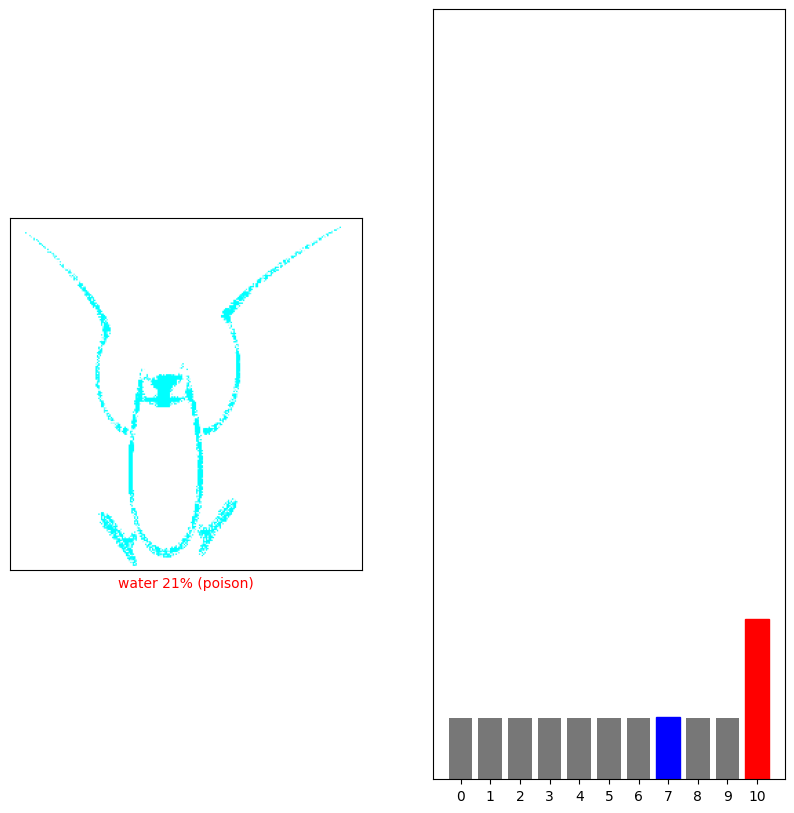

In [24]:
i = 10
ds = testing_ds

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
#for images, labels in test_ds.take(1):
iterator = iter(ds)
image, labels = next(iterator)
plot_image(i, predictions[i], labels, image)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels)
plt.show()

# Conclusion

The initial expectation of the project was that the results would not be useful.
However it was quickly apparent, that even with some very vague pokemon, a model could be found that reliably
classifies pokemon of the first generation.
While the problem of more modern generations with liberal interpretations of types is would still apply to bigger models with multiple generations, it is apparent that machine learning is a very powerful tool, even in the hands of novices.
